In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sparsecoding").getOrCreate()

import scipy.io
data = scipy.io.loadmat("/project/cmsc25025/sparsecoding/IMAGES_RAW.mat")
images = data["IMAGESr"]

import random
import numpy as np 

# image sampling/formatting functions

def sample_patches(image, num, width):
    patches = np.zeros([num,width*width]);
    for k in range(num):
        i, j = random.sample(range(image.shape[0]-width),2)
        patches[k,:] = np.array(image[i:i+width,j:j+width]).flatten()
    return patches

def format_patches(num, width):
    full_rdd = None
    for i in range(images.shape[2]):
        rdd = spark.sparkContext.parallelize(sample_patches(images[:,:,i],num,width))
        if full_rdd is None:
            full_rdd = rdd
        else:
            full_rdd = full_rdd.union(rdd)
    return full_rdd 

def format_codebook(num, width):
    patches = np.zeros([num*10,width*width])
    for i in range(images.shape[2]):
        patches[i*num:(i+1)*num,:] = sample_patches(images[:,:,i],num,width)
    return patches  

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# sparse coding/SGD helper functions

def OMP(norms,image,k):
    residual = image
    S=[0]*k
    Beta = None
    for i in range(k):
        S[i] = np.argmax(np.abs(np.dot(residual,X))/norms)
        Beta, _, _, _, = np.linalg.lstsq(X[:,S], image)
        residual = image - np.dot(X[:,S], Beta)
    return Beta, S

def findBeta(norms,Y,k):
    Betai, idx =  OMP(norms,Y,k)
    Beta = np.zeros(num_patches)
    for j in range(len(idx)): 
        Beta[idx[j]] = Betai[j]
    return Beta

def printcdb(width):
    nrows = 8
    ncols = 8
    plt.figure(figsize=(ncols, nrows))
    for j in xrange(nrows*ncols):
        plt.subplot(nrows, ncols, j+1)
        plt.imshow(X[:,j].reshape((width,width)), cmap='gray')
        plt.axis('off')       
    plt.axis('off')
    plt.show()

Note: only displaying 64 codewords, 200 total
0
Codebook after 0 iterations


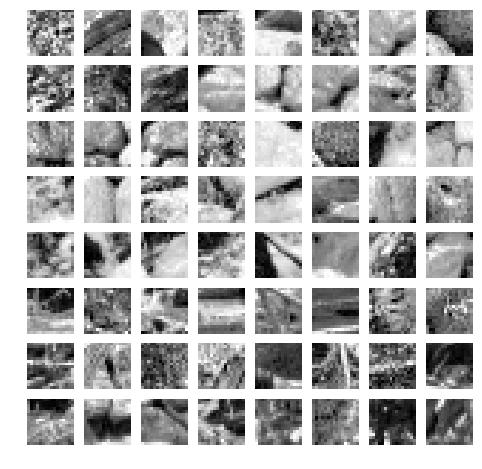

10
20
30
40
50
60
70
80
90
100
Codebook after 100 iterations


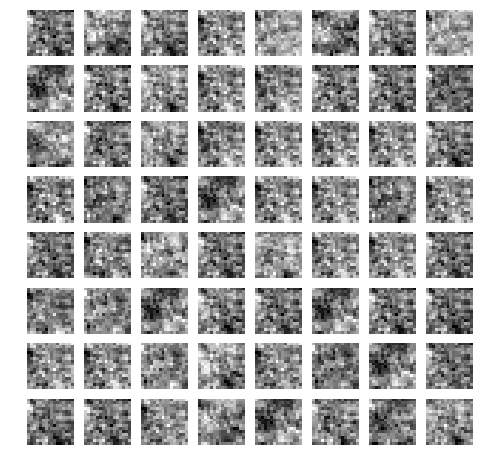

110
120
130
140
150
160
170
180
190
200
Codebook after 200 iterations


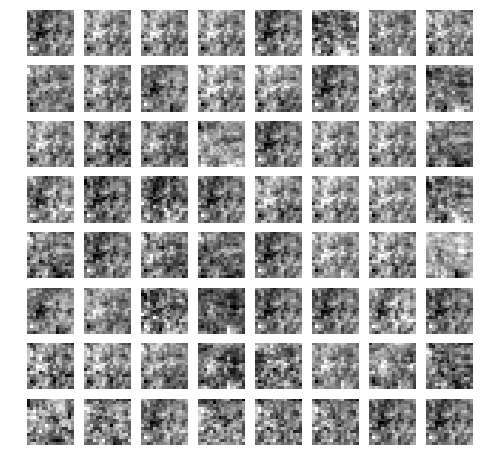

210
220
230
240
250
260
270
280
290
300
Codebook after 300 iterations


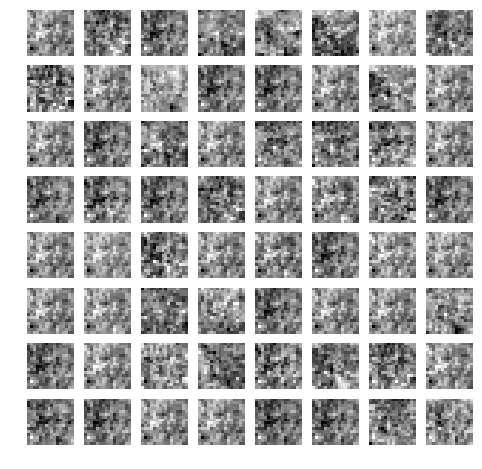

310
320
330
340
350
360
370
380
390
400
Codebook after 400 iterations


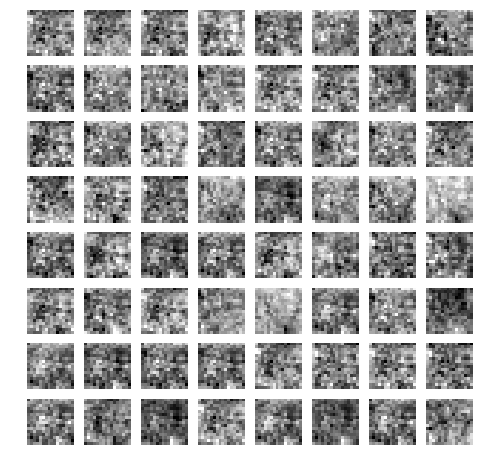

KeyboardInterrupt: 

In [3]:
# parameters
k = 10 # number of codewords to include in OMP
etta = 0.1 # learning rate
num_patches = 200 # number of codewords
Width = 16 # width of patches
N = 100 # number of sample patches at each iteration
max_iter = 2000 # maximum number of iterations

# initialize random codebook using sample patches from each image
X = np.transpose(format_codebook(num_patches/10,Width))

def SparseCodingSGD(max_iter):    
    
    print "Note: only displaying 64 codewords, %d total" % num_patches
    
    for k in range(max_iter):
        
        # step 1 - randomly sample N patches
        sample = format_patches(N/10,Width) # N x n matrix
        samples = np.array(sample.map(lambda x: [np.array(x)]).reduce(lambda a,b: a+b))
        
        # step 2 - get the beta coefficients for each image
        norms = np.linalg.norm(X,axis=0)
        Betas = sample.map(lambda x: [findBeta(norms, x, k)]).reduce(lambda a,b: a+b)
        
        # step 3 - compute gradients for each codeword
        for j in range(num_patches):
            negsum = 0
            for i in range(N):
                negsum += np.dot(Betas[i][j], samples[i,:] - np.dot(X, Betas[i]))
            gradient = -negsum
            X[:,j] = np.subtract(X[:,j] , etta*gradient)
            norm = np.linalg.norm(X[:,j])
            if (norm > 1): 
                X[:,j] = X[:,j] / norm
        
        
        if not k % 10: 
            print k 
        
        if not k % 100:
            print "Codebook after %d iterations" % k
            printcdb(Width) # codebook after several iterations of SGD
            
     
    print "Final codebook"
    printcdb(Width) # codebook at convergence

# update codebook with sparse coding and SGD
SparseCodingSGD(max_iter)

Original Image


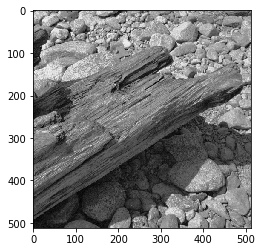

Reconstructed Image


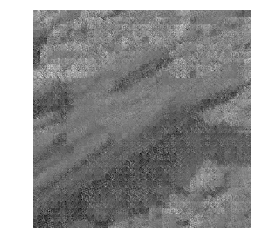

In [6]:
def SparseReconstruct(image):
    
    new_image = np.zeros((512,512))
    for i in range(0,512,Width):
        for j in range(0,512,Width):
            # reconstruct the patch
            norms = np.linalg.norm(X,axis=0) 
            Betas, idx = OMP(norms,image[i:i+Width,j:j+Width].flatten(),k)
            new_image[i:i+Width,j:j+Width] = X[:,idx].dot(Betas).reshape(Width,Width)
        
    return new_image

# display a reconstructed image
print "Original Image"
plt.figure()
plt.imshow(images[:,:,0], cmap='gray')
plt.show()

print "Reconstructed Image"
plt.figure()
plt.imshow(SparseReconstruct(images[:,:,0]), cmap='gray')
plt.axis('off')
plt.show()

We ran onlly 400 iterations for the codebook. Based on what we learned from class we now that we should have 2000 iterations but our code slowed down drastically at this number of iterations. In the codebooks displayed above you can see how after more iterations they stop changing. With a larger step size it takes a shorter term for convergence. We decided to use a step size of .3 because we felt it gave us the best tradeoff between performance and speed. Are codebook as presented above is a bit grainer then the one presented in class but it still shows edges pretty clearly. You can see the edges where there is essentially a line of darkness. You can also see our reconstruction of a couple of images above. This show how we were able to use the codeboom to reconstruct the images. Our images do not look quite as good as those in class but we also did not have nearly as many iterations as the ones from class did. 

Note: only displaying 64 codewords, 600 total
0
Codebook after 0 iterations


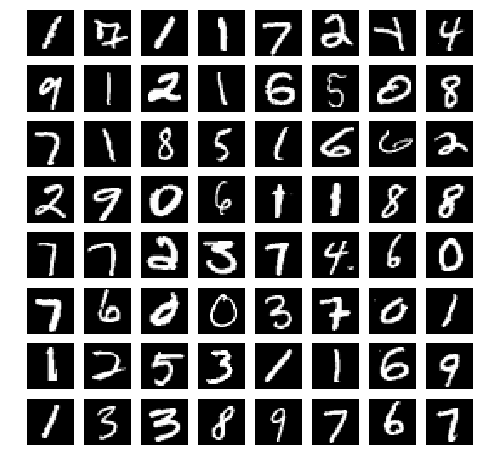

10
20
30
40
50
Codebook after 50 iterations


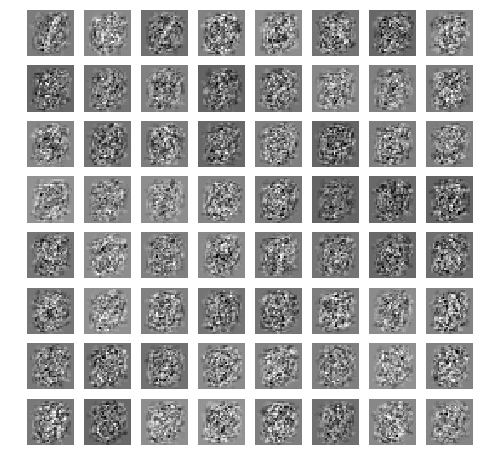

60
70
80
90
100
Codebook after 100 iterations


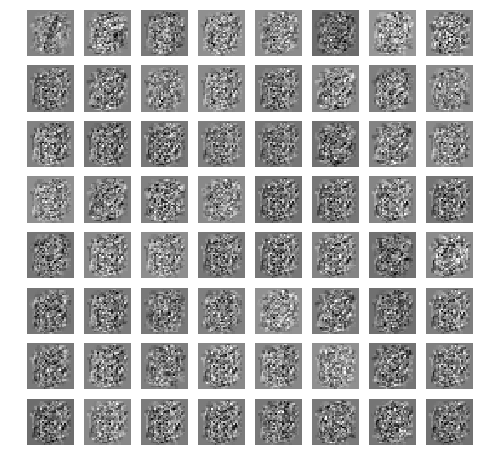

110
120
130
140
150
Codebook after 150 iterations


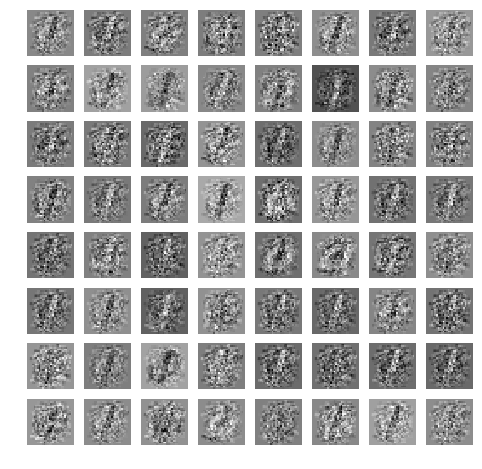

160
170
180
190
Final codebook


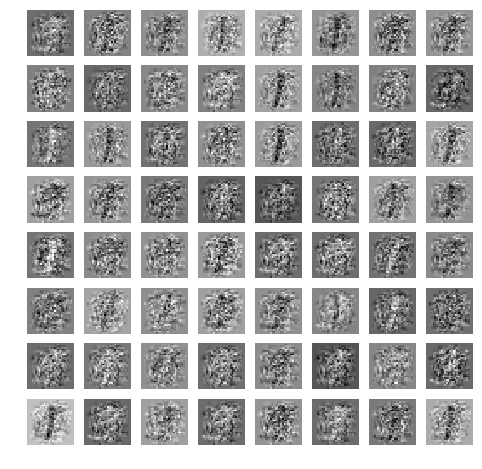

In [8]:
spark = SparkSession.builder.appName("mnist").getOrCreate()
df = spark.read.json('/project/cmsc25025/mnist/data.json')

# parameters
k = 10 # number of codewords to include in OMP
etta = 0.3 # learning rate
Width = 28
num_patches = 600 # number of codewords
N = 100 # number of sample patches at each iteration
max_iter = 200 # maximum number of iterations

def sample_patches_MNIST(num):
    sample = df.rdd.takeSample(False,num,seed=0)
    digits = [sample[i][0] for i in range(len(sample))]
    return np.array(digits)

def format_patches_MNIST(num):
    return spark.sparkContext.parallelize(sample_patches_MNIST(num))

# create codebook of sample digits
X = np.transpose(sample_patches_MNIST(num_patches))

def SparseCodingSGD_MNIST(max_iter):    
    
    print "Note: only displaying 64 codewords, %d total" % num_patches
    
    for k in range(max_iter):
        
        # step 0 - copy old codebook for comparison
        oldbook = np.copy(X)
        
        # step 1 - randomly sample N patches
        sample = format_patches_MNIST(N) # N x n matrix
        samples = np.array(sample.map(lambda x: [np.array(x)]).reduce(lambda a,b: a + b))
        
        # step 2 - get the beta coefficients for each image
        norms = np.linalg.norm(X,axis=0)
        Betas = sample.map(lambda x: [findBeta(norms, x, k)]).reduce(lambda a,b: a+b)
        
        # step 3 - compute gradients for each codeword
        for j in range(num_patches):
            negsum = 0
            for i in range(N):
                negsum += np.dot(Betas[i][j], samples[i,:] - np.dot(X, Betas[i]))
            gradient = -negsum
            X[:,j] = np.subtract(X[:,j] , etta * gradient)
            norm = np.linalg.norm(X[:,j])
            if (norm > 1): 
                X[:,j] = X[:,j] / norm
        if not k % 10: 
            print k 
        if not k % 50:
            print "Codebook after %d iterations" % k
            printcdb(Width) # codebook after several iterations of SGD
            
        if (abs(np.sum(np.subtract(X, oldbook))) < .005): # test for convergence
            print "Converged in %d iterations" % k
            break;
     
    print "Final codebook"
    printcdb(Width) # codebook at convergence

# update codebook with sparse coding and SGD
SparseCodingSGD_MNIST(max_iter)

Original Image


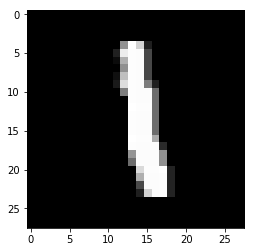

Reconstructed Image


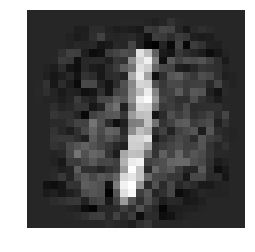

In [9]:
def SparseReconstruct_MNIST(image):

    norms = np.linalg.norm(X,axis=0) 
    Betas, idx = OMP(norms,image,k)
    new_image = X[:,idx].dot(Betas).reshape(Width,Width)   
    return new_image

# display a reconstructed image
digit = df.limit(10)
test_image = digit.rdd.map(lambda x: [np.array(x['features'])]).reduce(lambda a,b: a+b)


print "Original Image"
plt.figure()
plt.imshow(test_image[6].reshape(Width,Width), cmap='gray')
plt.show()

print "Reconstructed Image"
plt.figure()
plt.imshow(SparseReconstruct_MNIST(test_image[6]), cmap='gray')
plt.axis('off')
plt.show()

Above you can see how we ran Sparce coding on the mnist data. The codebook is displayed for different values. The Mnists data took longer to run then the other images because we are sampling the entire photos rather than just patches from a photo. In the codebook the first thing you see is that the middle is a different color than the outside. This is because all of the digits are in the middle of the photos. You also begin to see after a bunch of iterations different lines inside of the middle section. This is showing different features of the numbers. In this representation you see different lines wheras in the PCA representation you could actually see different numbers. This is because with sparse coding we have a lot more vectors and so not every single one has to be orthogonal to each other. Also because we are running it on all the digits rather than a single digit we see things that are common to all numbers such as certain lines rather than actual numbers in the codebook. When I ran the sparse coding on only certain digits of the mnist data then the codebook showed lots of different images of that specefic digit. 



